# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science



## Group #20: Final Project - World Cup Predictions 

**Harvard University**<br>
**Fall 2018**<br>

# Feature Engineering

## 1 - Notebook Configuration

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# display preferences
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

## 2 - Custom Functions

In [2]:
# function to calculate rolling exponentioally weighted moving average
def rwma(group, min_periods, span):
    # perform the ewma
    kwargs = dict(ignore_na=False, span=span, min_periods=min_periods, adjust=True)
    result = group.ewm(**kwargs).mean().shift().reset_index()
    result.rename(columns={result.columns[-1]: 'rwma'}, inplace=True)
    return result

In [3]:
# function to calculate rolling weighted moving average
def rmean(group,min_periods):
    # perform the mean
    kwargs = dict(window='3650d', min_periods=min_periods, win_type=None)
    #kwargs = dict(window='1825d', min_periods=min_periods, win_type=None)
    result = group.rolling(**kwargs).mean().shift().reset_index()
    result.rename(columns={result.columns[-1]: 'rmean'}, inplace=True)
    return result

## 3 - Load Data, Examine and Prep

In [4]:
df = pd.read_csv("data/team/new_intl_results.csv")

In [5]:
# note: some teams played twice on certain dates (e.g. Chile on 5/30/2010)

In [6]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30 00:00:00,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08 00:00:00,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07 00:00:00,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06 00:00:00,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04 00:00:00,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [7]:
df.date = df.date.values.astype("datetime64")
df['year'] = pd.DatetimeIndex(df['date']).year

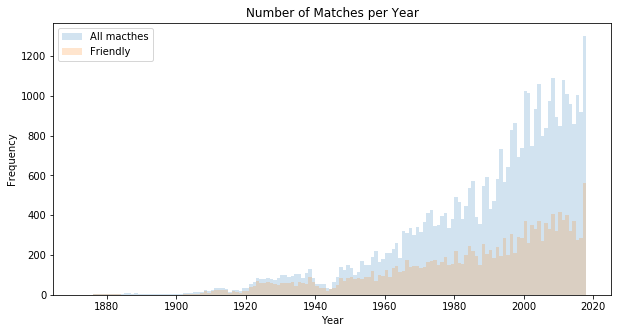

In [8]:
# create yearly bins for plotting
year_bins = np.linspace(min(df.year),max(df.year), max(df.year) - min(df.year) + 1)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df['year'], bins = year_bins, alpha = 0.2, label = 'All macthes')
ax.hist(df[df['tournament'] == 'Friendly']['year'], bins = year_bins, alpha = 0.2, label = 'Friendly')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Number of Matches per Year')
ax.legend()
plt.show()

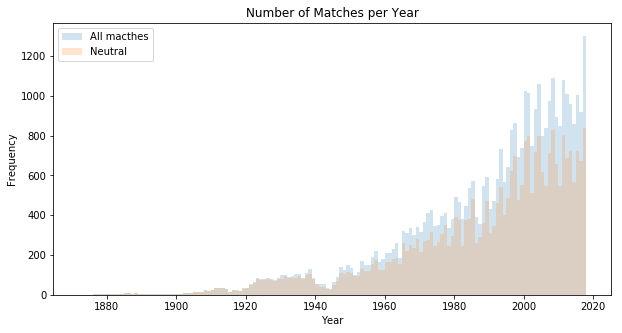

In [9]:
# create yearly bins for plotting
year_bins = np.linspace(min(df.year),max(df.year), max(df.year) - min(df.year) + 1)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df['year'], bins = year_bins, alpha = 0.2, label = 'All macthes')
ax.hist(df[df['neutral'] == 0]['year'], bins = year_bins, alpha = 0.2, label = 'Neutral')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Number of Matches per Year')
ax.legend()
plt.show()

In [10]:
# Find first available date after historical gap in dates
#start_date = min(df[df['year'] >= 1940]['date'])
#print('First date available after historical gap: {}'.format(start_date))

Two observations:
 - REMOVE - It looks like history is not truly available all the back to 1872. For feature engineering purposes, we will opt to ignore soccer matches prior to 1/1/1968.
 - A high percentage of matches fall in the 'Friendly' category.  We will have to make a decision in terms of how to include these matches in our feature engineering process.  The decision will be made based on which approach (i.e. to include or not to include Friendlies) performs best.


Let's remove the friendly matches from the dataset.  The friendly matches represent a high percentage of the data set, but friendly matches do not have the same stakes and therefore do not help us assess the true ability of teams.

In [11]:
# Exclude world cup matches
df = df[df['date'] < '2018-06-14']

# Exclude Friendlies
#df = df[df['tournament'] != 'Friendly']

## 4 - Create Intermediary Features

### 4.1 Result

In [12]:
# result variable
# constructed as follows:
# 1 for win
# 0 for draw
# -1 for loss
df['result'] = np.sign(df.home_score - df.away_score)

### 4.2 Result-Plus

In [13]:
# result adjusted for venue
# -0.5 penalty if result obtained on home soil
# +0.5 reward if result obtained on opponent soil 
# Note: no penalty if achieved on neutral field)
df['result_plus'] = np.sign(df.home_score - df.away_score) - (.25 * (df.neutral==False))

### 4.3 Sorted Match-Up

In [14]:
# Create a lookup value for all unique historical match-ups

df['sorted_matchup'] = np.where(df['home_team'] < df['away_team'], 
                                df['home_team'] + '|' + df['away_team'],
                                df['away_team'] + '|' + df['home_team'])

### 4.4 Sorted Match-Up Result

In [15]:
# Store result of the sorted match up
df['sorted_result'] = np.where(df['home_team'] < df['away_team'], 
                               df['result'] ,
                               df['result'] * -1)

### 4.5 Sorted Match-Up Result-Plus

In [16]:
# Store "result plus" for the sorted match up
df['sorted_result_plus'] = np.where(df['home_team'] < df['away_team'], 
                                    df['result_plus'] ,
                                    df['result_plus'] * -1)

## 5 - Create Model Features

Now that the required intermediary fearures have been created, we will go on to split our data set into training and testing subsets.

In [17]:
df = df.sort_values('date')

In [18]:
# split the data features generated on the training dataset 
# will be copied over to test dataset later on

# train_df = df[df['date'] <= '2018-06-13']
# test_df = df[df['date'] > '2018-06-13']


In [19]:
#train_df[train_df.neutral == False].head()

In [20]:
df.set_index('date',inplace=True,drop=True)

In [21]:
# check output
#df[df['sorted_matchup'] == 'Brazil|France']

### 5.1 - Historical Record vs Opponent

Defintions:
 - **Historical Record vs Opponent:**
     - **Variable Name**: hrvo_rwma
     - **Description**: Lagging indicator of past performance vs opponent based on _results_ variable



 - **Historical Record vs Opponent "Plus":**
     - **Variable Name**: hrvop_rwma
     - **Description**: Lagging indicator of past performance vs opponent based on _results-plus_ variable

### 5.1.1 - Generate Features

In [22]:
# create new dataframe (df_vs_oppo) to store rolling record vs opponent using custom rolling weighted average function (rwma)
df_vs_oppo  = df.groupby('sorted_matchup')[['sorted_result','sorted_result_plus']].apply(rwma,0,5)

df.reset_index(inplace=True)

In [23]:
# rename columns, as group by generates undesirable column names
df_vs_oppo = df_vs_oppo.rename(columns={'sorted_result':'hrvo_rwma', 
                                        'rwma':'hrvop_rwma' })

df_vs_oppo.reset_index(inplace=True)

df_vs_oppo = df_vs_oppo.drop(columns = 'level_1')

# fill first match-up where values for sorted_result_rwma and sorted_result_plus_rwma will always be N/A with zeroes.
df_vs_oppo['hrvo_rwma'] = df_vs_oppo['hrvo_rwma'].fillna(0)
df_vs_oppo['hrvop_rwma'] = df_vs_oppo['hrvop_rwma'].fillna(0)

### 5.1.2 - Examine Features

Let's take a look at match results vs our newly engineered variables:

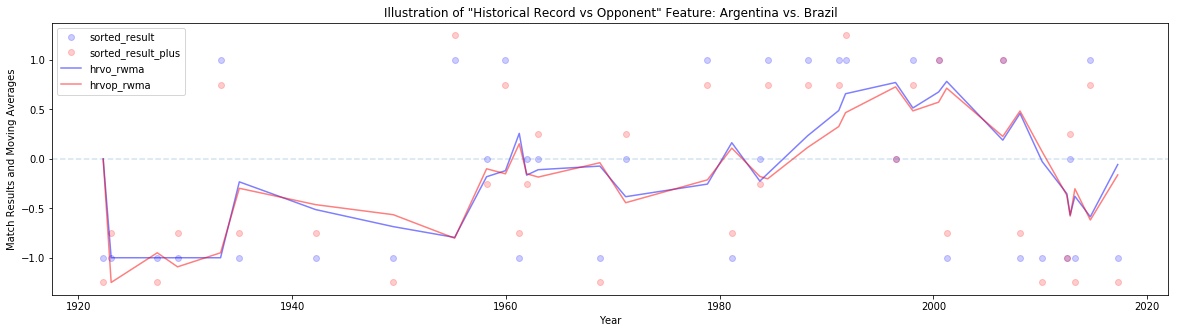

In [24]:
temp_df = df[df['sorted_matchup'] == 'France|Spain']

temp_df_vs_oppo = df_vs_oppo[df_vs_oppo['sorted_matchup'] == 'France|Spain']

fig, ax = plt.subplots(1,1,figsize = (20,5))

ax.plot(temp_df['date'] , temp_df['sorted_result'], 'o', label = 'sorted_result', alpha = 0.2, color = 'blue')
ax.plot(temp_df['date'] , temp_df['sorted_result_plus'] , 'o', label = 'sorted_result_plus', alpha = 0.2, color = 'red')
ax.plot(temp_df_vs_oppo['date'] , temp_df_vs_oppo['hrvo_rwma'] , '-', label = 'hrvo_rwma', alpha = 0.5, color = 'blue')
ax.plot(temp_df_vs_oppo['date'] , temp_df_vs_oppo['hrvop_rwma'] , '-', label = 'hrvop_rwma', alpha = 0.5, color = 'red')
ax.axhline(0, linestyle = '--', alpha = 0.2)

ax.set_xlabel('Year')
ax.set_ylabel('Match Results and Moving Averages')
ax.set_title('Illustration of "Historical Record vs Opponent" Feature: Argentina vs. Brazil')

ax.legend()
plt.show()

In [77]:
pair_plot_df = df[['sorted_matchup', 'date','sorted_result','sorted_result_plus']].merge(df_vs_oppo[['sorted_matchup','date','hrvo_rwma','hrvop_rwma']], 
                  how = 'inner',
                  left_on=['sorted_matchup','date'], 
                  right_on=['sorted_matchup','date'])

In [78]:
df_vs_oppo

,sorted_matchup,date,hrvo_rwma,hrvop_rwma
0,Abkhazia|Chagos Islands,2016-05-29,0.000000,0.000000
1,Abkhazia|Kabylia,2018-06-09,0.000000,0.000000
2,Abkhazia|Kárpátalja,2017-06-06,0.000000,0.000000
3,Abkhazia|Kárpátalja,2018-06-02,0.000000,-0.000000
4,Abkhazia|Northern Cyprus,2016-06-04,0.000000,0.000000
5,Abkhazia|Northern Cyprus,2017-06-07,1.000000,0.750000
6,Abkhazia|Northern Cyprus,2018-06-03,0.400000,0.450000
7,Abkhazia|Occitania,2014-06-01,0.000000,0.000000
8,Abkhazia|Occitania,2014-06-07,0.000000,0.000000
9,Abkhazia|Padania,2014-06-05,0.000000,0.000000


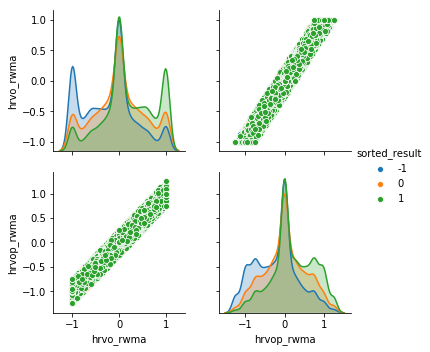

In [82]:
# Look at Argentina vs Brazil
temp_pair_plot_df = pair_plot_df[pair_plot_df['sorted_matchup'] == 'Argentina|Brazil']

#sns.pairplot(temp_pair_plot_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")
sns.pairplot(pair_plot_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

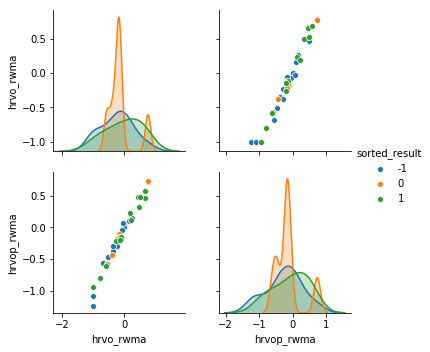

In [27]:
# Look at France vs Spain
temp_pair_plot_df = pair_plot_df[pair_plot_df['sorted_matchup'] == 'France|Spain']
sns.pairplot(temp_pair_plot_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

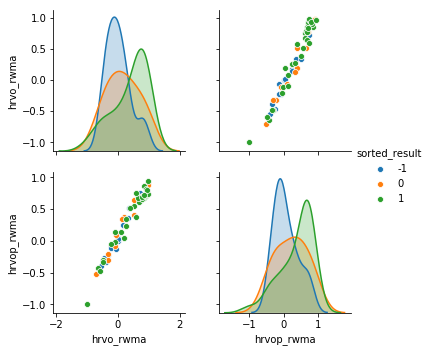

In [28]:
# Look at France vs Spain
temp_pair_plot_df = pair_plot_df[pair_plot_df['sorted_matchup'] == 'Mexico|USA']
sns.pairplot(temp_pair_plot_df, vars = ['hrvo_rwma' , 'hrvop_rwma'] , hue="sorted_result")

Based on the above, it would appear that neither variable is highly related to match results, but it seems that hrvop_rwma might be a little bit better than hrvo_rwma.

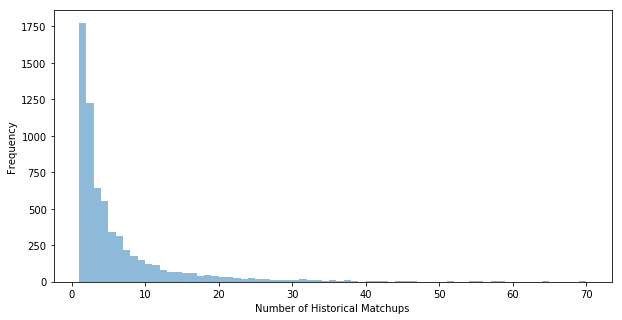

In [29]:
# Check how many matches have taken place for all the matchups in our data set.
matchup_bins = np.linspace(4,99,20)
matchup_bins = np.linspace(1,70,70)
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(df_vs_oppo.groupby('sorted_matchup').size(), bins = matchup_bins, alpha = .5)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Historical Matchups')
plt.show()

Based on the histogram above, it becomes apparent that most many teams have only played each other only once or twice. 
The Historical Record vs Opponent features may therefore not be all that useful because many teams have only played each other on one or two occasions.
This feature may become more useful once the dataset shrinks to teams that are available in our other data sets (sofifa.com, etc.), but this remains to be seen.

### 5.2 - Historical Record vs All Opponents

Defintions:
 - **Historical Record vs All:**
     - **Variable Name**: hrva_rwma
     - **Description**: Lagging indicator of past performance vs all opponents based on _results_ variable



 - **Historical Record vs All "Plus":**
     - **Variable Name**: hrvap_rwma
     - **Description**: Lagging indicator of past performance vs all opponents based on _results-plus_ variable

### 5.2.1 - Generate Features

In [30]:
# Manipulate international results to get a dataframe that looks as follows:

# Date | home | team | tournament | result 

#df_home
df_home = pd.DataFrame(df, 
                       columns = ['date','home_team','tournament','result','result_plus'], 
                       copy = True)
df_home = df_home.rename(columns = {"home_team" : "team"})
df_home['home'] = 1

In [31]:
#df_away
df_away = pd.DataFrame(df, columns = ['date','away_team','tournament'], 
                       copy = True)
df_away = df_away.rename(columns = {"away_team" : "team"})
df_away['result'] = df['result'] * - 1
df_away['result_plus'] = df['result_plus'] * - 1
df_away['home'] = 0

In [32]:
#df_tall (combo of df_home and df_away)
df_tall = df_home.append(df_away, sort = True)

df_tall = df_tall.sort_values('date')

df_tall.set_index('date',inplace=True,drop=True)

#print(len(train_df))
#print(len(df_tall))
df_tall.head()



,home,result,result_plus,team,tournament
date,,,,,
1872-11-30,1,0,-0.25,Scotland,Friendly
1872-11-30,0,0,0.25,England,Friendly
1873-03-08,1,1,0.75,England,Friendly
1873-03-08,0,-1,-0.75,Scotland,Friendly
1874-03-07,1,1,0.75,Scotland,Friendly


In [33]:
# Create fake rows to store forward int'l ranking

fake_df = pd.DataFrame(df_tall.team.unique(),columns=['team'])
fake_df['date'] = '2099-12-31'
fake_df.date = fake_df.date.values.astype("datetime64")
fake_df['home'] = '0'
fake_df['result'] = '0'
fake_df['result_plus'] = '0'
fake_df['tournament'] = 'Placeholder'
fake_df.set_index('date', inplace=True)
fake_df.head()

,team,home,result,result_plus,tournament
date,,,,,
2099-12-31,Scotland,0,0,0,Placeholder
2099-12-31,England,0,0,0,Placeholder
2099-12-31,Wales,0,0,0,Placeholder
2099-12-31,Northern Ireland,0,0,0,Placeholder
2099-12-31,USA,0,0,0,Placeholder


In [34]:
df_tall = pd.concat([df_tall,fake_df], sort=True)

In [35]:
df_tall.head()

,home,result,result_plus,team,tournament
date,,,,,
1872-11-30,1,0,-0.25,Scotland,Friendly
1872-11-30,0,0,0.25,England,Friendly
1873-03-08,1,1,0.75,England,Friendly
1873-03-08,0,-1,-0.75,Scotland,Friendly
1874-03-07,1,1,0.75,Scotland,Friendly


### 5.2.2 - Examine Features

In [36]:
overall_record_rwma_df = df_tall.groupby('team')['result'].apply(rwma,0,50)
overall_record_rwmap_df = df_tall.groupby('team')['result_plus'].apply(rwma,0,50)

overall_record_rmean_df = df_tall.groupby('team')['result'].apply(rmean,0)
overall_record_rmeanp_df = df_tall.groupby('team')['result_plus'].apply(rmean,0)

overall_record_df = overall_record_rwma_df.copy()

In [37]:
overall_record_df = overall_record_df.rename(columns = {'rwma':'hrva_rwma'})

overall_record_df['hrvap_rwma'] = overall_record_rwmap_df['rwma']

overall_record_df['hrva_rmean'] = overall_record_rmean_df['rmean']

overall_record_df['hrvap_rmean'] = overall_record_rmeanp_df['rmean']

In [38]:
overall_record_df.head()

date  hrva_rwma  hrvap_rwma  hrva_rmean  hrvap_rmean
team                                                                 
Abkhazia 0 2014-06-01        NaN         NaN         NaN          NaN
         1 2014-06-02   0.000000    0.000000    0.000000     0.000000
         2 2014-06-04   0.510000    0.637500    0.500000     0.625000
         3 2014-06-05   0.333156    0.416444    0.333333     0.416667
         4 2014-06-07   0.244804    0.306005    0.250000     0.312500

In [39]:
overall_record_df.reset_index(inplace=True)

overall_record_df.drop(columns='level_1', inplace= True)

overall_record_df.hrva_rwma = overall_record_df.hrva_rwma.fillna(0)

overall_record_df.hrvap_rwma = overall_record_df.hrvap_rwma.fillna(0)

overall_record_df.hrva_rmean = overall_record_df.hrva_rmean.fillna(0)

overall_record_df.hrvap_rmean = overall_record_df.hrvap_rmean.fillna(0)



In [40]:
overall_record_df[overall_record_df['team'] == 'France'].head(10)

,team,date,hrva_rwma,hrvap_rwma,hrva_rmean,hrvap_rmean
23346,France,1904-05-01,0.000000,0.000000,0.000000,0.000000
23347,France,1905-02-12,0.000000,0.250000,0.000000,0.250000
23348,France,1905-05-07,0.510000,0.505000,0.500000,0.500000
23349,France,1906-04-22,-0.013598,0.069824,0.000000,0.083333
23350,France,1907-04-21,-0.275188,-0.280188,-0.250000,-0.250000
23351,France,1908-03-08,0.000652,0.050812,0.000000,0.050000
23352,France,1908-04-12,0.184301,0.271185,0.166667,0.250000
23353,France,1908-05-10,-0.005850,0.026945,0.000000,0.035714
23354,France,1909-05-09,-0.148197,-0.084302,-0.125000,-0.062500
23355,France,1910-04-03,-0.258675,-0.170643,-0.222222,-0.138889


In [41]:
overall_record_df[overall_record_df['team'] == 'France'].tail(10)

,team,date,hrva_rwma,hrvap_rwma,hrva_rmean,hrvap_rmean
24150,France,2017-10-07,0.452248,0.359116,0.330827,0.276316
24151,France,2017-10-10,0.473728,0.394053,0.348485,0.295455
24152,France,2017-11-10,0.494366,0.408011,0.348485,0.291667
24153,France,2017-11-14,0.514195,0.421423,0.348485,0.291667
24154,France,2018-03-23,0.494031,0.414700,0.348485,0.295455
24155,France,2018-03-27,0.435441,0.349418,0.351145,0.291985
24156,France,2018-05-28,0.457581,0.384735,0.351145,0.295802
24157,France,2018-06-01,0.478852,0.399059,0.351145,0.295802
24158,France,2018-06-09,0.499289,0.412821,0.353846,0.300000
24159,France,2099-12-31,0.479709,0.386828,0.353846,0.298077


In [42]:
temp_df1 = overall_record_df[(overall_record_df['team'] == 'France') & (overall_record_df['date'] < '2099-12-31')]
temp_df2 = overall_record_df[(overall_record_df['team'] == 'Spain')  & (overall_record_df['date'] < '2099-12-31')]
temp_df3 = df_vs_oppo[df_vs_oppo['sorted_matchup'] == 'France|Spain']

In [43]:
temp_df3.tail()

,sorted_matchup,date,hrvo_rwma,hrvop_rwma
20328,France|Spain,2012-06-23,-0.351197,-0.367847
20329,France|Spain,2012-10-16,-0.567465,-0.578565
20330,France|Spain,2013-03-26,-0.378310,-0.302376
20331,France|Spain,2014-09-04,-0.585540,-0.618251
20332,France|Spain,2017-03-28,-0.057026,-0.162167


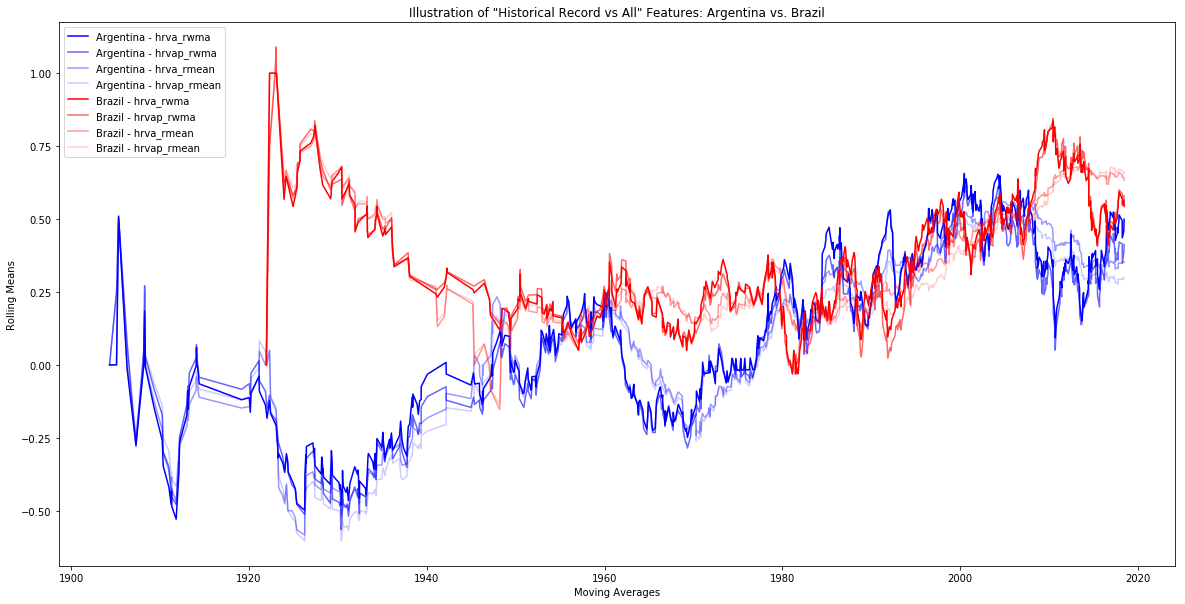

In [44]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

ax.plot(temp_df1['date'], temp_df1['hrva_rwma'], label = 'Argentina - hrva_rwma', color = 'blue', alpha = 1)
ax.plot(temp_df1['date'], temp_df1['hrvap_rwma'], label = 'Argentina - hrvap_rwma', color = 'blue', alpha = 0.60)

ax.plot(temp_df1['date'], temp_df1['hrva_rmean'], label = 'Argentina - hrva_rmean', color = 'blue', alpha = .40)
ax.plot(temp_df1['date'], temp_df1['hrvap_rmean'], label = 'Argentina - hrvap_rmean', color = 'blue', alpha = .20)


ax.plot(temp_df2['date'], temp_df2['hrva_rwma'], label = 'Brazil - hrva_rwma', color = 'red', alpha = 1)
ax.plot(temp_df2['date'], temp_df2['hrvap_rwma'], label = 'Brazil - hrvap_rwma', color = 'red', alpha = 0.60)

ax.plot(temp_df2['date'], temp_df2['hrva_rmean'], label = 'Brazil - hrva_rmean', color = 'red', alpha = .40)
ax.plot(temp_df2['date'], temp_df2['hrvap_rmean'], label = 'Brazil - hrvap_rmean', color = 'red', alpha = .20)

ax.set_xlabel('Moving Averages')
ax.set_ylabel('Rolling Means')
ax.set_title('Illustration of "Historical Record vs All" Features: Argentina vs. Brazil')

plt.legend()
plt.show()

## 6  - Merge Features Back into Project Dataset

In [45]:
project_df = pd.read_csv("data/team/M4_data_nikhil.csv")
project_df.date = project_df.date.values.astype("datetime64")

project_df = project_df.sort_values(['date','home_team','away_team'])
overall_record_df = overall_record_df.sort_values(['date','team'])

overall_record_df.to_csv('data/team/overall_record_df.csv')

In [46]:
# truncate feature from because after 1 st round of wc matches because wc data set is unknown
#overall_record_trunc_df = overall_record_df[overall_record_df['date'] <= '18-jun-2018']

#overall_record_df = overall_record_df.loc[overall_record_df.groupby('team').date.idxmax()]

In [47]:
#print(len(project_df))

merge_columms = ['date','team', # for joins
                 'hrva_rwma','hrvap_rwma','hrva_rmean','hrvap_rmean']

final_df = pd.merge_asof(project_df, overall_record_df[merge_columms], 
                  left_on=['date'],
                  right_on=['date'],                    
                  left_by = ['home_team'], 
                  right_by = ['team'], 
                  direction = 'forward',
                  allow_exact_matches = True)

final_df = final_df.drop(columns = 'team')

final_df = final_df.rename(columns={'hrva_rwma':'home_hrva_rwma', 
                                    'hrvap_rwma':'home_hrvap_rwma',
                                    'hrva_rmean':'home_hrva_rmean',
                                    'hrvap_rmean': 'home_hrvap_rmean'
                                    })

#print(len(final_df))

In [48]:
print(len(project_df))

final_df = pd.merge_asof(final_df, overall_record_df[merge_columms], 
                  left_on=['date'],
                  right_on=['date'],                    
                  left_by = ['away_team'], 
                  right_by = ['team'], 
                  direction = 'forward',
                  allow_exact_matches = True)


final_df = final_df.drop(columns = 'team')

#train_df.head()

final_df = final_df.rename(columns={'hrva_rwma':'away_hrva_rwma', 
                                    'hrvap_rwma':'away_hrvap_rwma',
                                    'hrva_rmean':'away_hrva_rmean',
                                    'hrvap_rmean': 'away_hrvap_rmean'
                                    })

print(len(final_df))

1639
1639


In [49]:
#final_df.info()

In [50]:
final_df.to_csv('data/team/final_df.csv')

In [51]:
final_df['diff_hrva_rwma']   = final_df['home_hrva_rwma']   - final_df['away_hrva_rwma']
final_df['diff_hrvap_rwma']  = final_df['home_hrvap_rwma']  - final_df['away_hrvap_rwma']
final_df['diff_hrva_rmean']  = final_df['home_hrva_rmean']  - final_df['away_hrva_rmean']
final_df['diff_hrvap_rmean'] = final_df['home_hrvap_rmean'] - final_df['away_hrvap_rmean']

In [52]:
# Look at France vs Italy
temp_pair_plot_df = final_df[(final_df['home_team'] == 'Argentina') & (final_df['away_team'] == 'Brazil')]

temp_pair_plot_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_rank,...,home_hrva_rmean,home_hrvap_rmean,away_hrva_rwma,away_hrvap_rwma,away_hrva_rmean,away_hrvap_rmean,diff_hrva_rwma,diff_hrvap_rwma,diff_hrva_rmean,diff_hrvap_rmean
139,2010-11-17,Argentina,Brazil,1,0,Friendly,Doha,Qatar,1,5,...,0.443548,0.487903,0.682004,0.733183,0.483444,0.529801,-0.208879,-0.250251,-0.039895,-0.041898
322,2011-09-14,Argentina,Brazil,0,0,Friendly,Córdoba,Argentina,0,9,...,0.409091,0.441288,0.481206,0.515303,0.513889,0.559028,-0.052753,-0.115849,-0.104798,-0.117740
574,2012-11-21,Argentina,Brazil,2,1,Friendly,Buenos Aires,Argentina,0,3,...,0.417266,0.447842,0.572194,0.594870,0.510345,0.562069,-0.155835,-0.166457,-0.093079,-0.114227
920,2014-10-11,Argentina,Brazil,0,2,Friendly,Beijing,China,1,2,...,0.422222,0.442593,0.501157,0.420045,0.540541,0.550676,0.011624,0.116031,-0.118318,-0.108083
1095,2015-11-13,Argentina,Brazil,1,1,FIFA World Cup qualification,Buenos Aires,Argentina,0,3,...,0.415385,0.434615,0.551902,0.511430,0.575540,0.582734,-0.190923,-0.121209,-0.160155,-0.148118


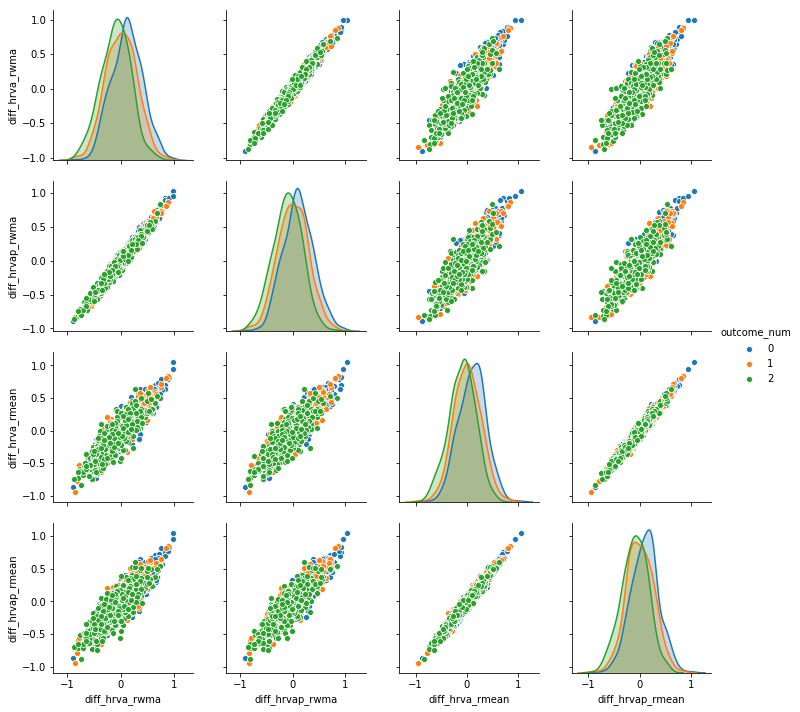

In [53]:
sns.pairplot(final_df, 
             vars = ['diff_hrva_rwma' , 'diff_hrvap_rwma' , 'diff_hrva_rmean' , 'diff_hrvap_rmean'] , 
             hue="outcome_num")

# Remove later - start

In [64]:
x_train = final_df[['diff_hrvap_rmean']]
y_train = final_df['outcome_num']

In [65]:
x_test = final_df[['diff_hrvap_rmean']]
y_test = final_df['outcome_num']

In [66]:
simple_logistic_model = LogisticRegressionCV(multi_class = 'ovr', cv=5, penalty='l2')
simple_logistic_model.fit(x_train, y_train)

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(x_train, y_train)
qda.fit(x_train, y_train)

print('Logistic Regression Train Score: ',simple_logistic_model.score(x_train, y_train))
print('Logistic Regression CV Train Score: ',cross_val_score(simple_logistic_model, x_train, y_train, cv=5).mean())
print('LDA Train Score: ',lda.score(x_train, y_train))
print('LDA CV Train Score: ',cross_val_score(lda, x_train, y_train, cv=5).mean())
print('QDA Train Score: ',qda.score(x_train, y_train))
print('QDA CV Train Score: ',cross_val_score(qda, x_train, y_train, cv=5).mean())

Logistic Regression Train Score:  0.484441732764
Logistic Regression CV Train Score:  0.48500433966
LDA Train Score:  0.482001220256
LDA CV Train Score:  0.480115102694
QDA Train Score:  0.481391092129
QDA CV Train Score:  0.480133647959


In [67]:
# choosing lda and qda as they both produced very similar scores on CV data
print('Logistic Regression Test Score: ',simple_logistic_model.score(x_test, y_test))
print('LDA Test Score: ',lda.score(x_test, y_test))
print('QDA Test Score: ',qda.score(x_test, y_test))

Logistic Regression Test Score:  0.484441732764
LDA Test Score:  0.482001220256
QDA Test Score:  0.481391092129


In [68]:
# confusion matrix for the logistic regression model
pd.crosstab(np.array(y_test), simple_logistic_model.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,2,All
Actual,,,
0,620,111,731
1,325,112,437
2,297,174,471
All,1242,397,1639


In [69]:
# confusion matrix for the lda model
pd.crosstab(np.array(y_test), lda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,2,All
Actual,,,
0,607,124,731
1,314,123,437
2,288,183,471
All,1209,430,1639


In [70]:
# confusion matrix for the qda model
pd.crosstab(np.array(y_test), qda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,2,All
Actual,,,
0,601,130,731
1,308,129,437
2,283,188,471
All,1192,447,1639


In [71]:
final_df.to_csv('data/team/final_dataset.csv')

In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 1638
Data columns (total 78 columns):
date                                1639 non-null datetime64[ns]
home_team                           1639 non-null object
away_team                           1639 non-null object
home_score                          1639 non-null int64
away_score                          1639 non-null int64
tournament                          1639 non-null object
city                                1639 non-null object
country                             1639 non-null object
neutral                             1639 non-null int64
home_rank                           1639 non-null int64
home_rank_pts                       1639 non-null int64
away_rank                           1639 non-null int64
away_rank_pts                       1639 non-null int64
rank_diff                           1639 non-null int64
rank_pts_diff                       1639 non-null int64
outcome                             163

In [73]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 646
Data columns (total 66 columns):
date                                1639 non-null datetime64[ns]
home_team                           1639 non-null object
away_team                           1639 non-null object
home_score                          1639 non-null int64
away_score                          1639 non-null int64
tournament                          1639 non-null object
city                                1639 non-null object
country                             1639 non-null object
neutral                             1639 non-null int64
home_rank                           1639 non-null int64
home_rank_pts                       1639 non-null int64
away_rank                           1639 non-null int64
away_rank_pts                       1639 non-null int64
rank_diff                           1639 non-null int64
rank_pts_diff                       1639 non-null int64
outcome                             1639